# Hanzi OCR
### Modeled from EasyOCR and TorchfreeEasyOCR

In [129]:
import os
import numpy as np
import cv2
import math
import onnxruntime
import matplotlib.pyplot as plt

### Normalize from 0..255 to -1.0..1.0

In [130]:
class NormalizePAD:
    def __init__(self, max_size, PAD_type='right'):
        self.max_size = max_size  # (C, H, W)
        self.max_width_half = math.floor(max_size[2] / 2)
        self.PAD_type = PAD_type

    def __call__(self, img):
        img = np.array(img, dtype=np.float32) / 255.0  # Normalize
        img = (img - 0.5) / 0.5  # Scale between -1 and 1

        if img.ndim == 2:  # If grayscale (H, W), add channel dim
            img = np.expand_dims(img, axis=0)  # Now shape is (1, H, W)

        c, h, w = self.max_size
        Pad_img = np.zeros((c, h, w), dtype=np.float32)  # Zero-filled array of max_size

        # Ensure input fits in the padding space
        img_c, img_h, img_w = img.shape
        Pad_img[:, :, :img_w] = img  # Right pad

        if img_w < w:  # Add border padding
            Pad_img[:, :, img_w:] = np.expand_dims(img[:, :, img_w - 1], axis=2).repeat(w - img_w, axis=2)

        return Pad_img

### Plot image

In [131]:
def plt_img(im):
    plt.imshow(im, cmap='gray')
    plt.title('Input')
    plt.show()

### Files

In [140]:
img_file = os.path.expanduser('~/dev/mandarin/images/c1.png')
recognizer_file = os.path.expanduser('~/.TorchfreeOCR/model/zh_tra_g1_rec.onnx')
fixed_recognizer_file = os.path.expanduser('~/.TorchfreeOCR/model/zh_tra_g1_rec.fixed.onnx')

### Read in the image

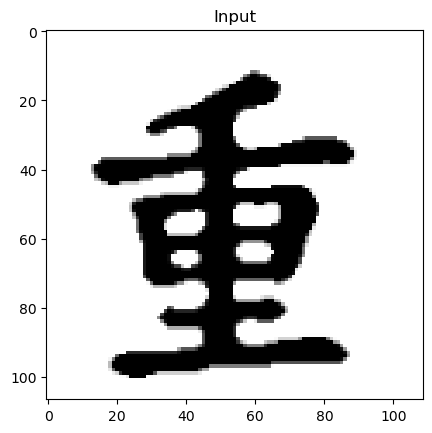

(107, 109)

In [133]:
img0 = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
plt_img(img0)
height, width = img0.shape
height, width

### Initial scale to 64

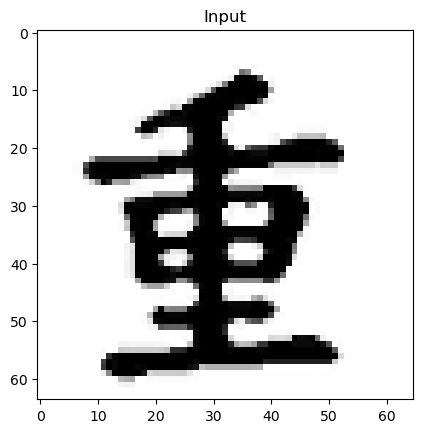

(64, 65), 1.0186915887850467


In [134]:
model_height = 64
ratio = width / height
if ratio < 1.0:
    ratio = 1. / ratio
    # resize takes (cols, rows)
    img = cv2.resize(img0, (model_height, int(model_height*ratio)),
                        interpolation=cv2.INTER_LANCZOS4)
else:
    # resize takes (cols, rows)
    img = cv2.resize(img0, (int(model_height*ratio), model_height),
                        interpolation=cv2.INTER_LANCZOS4)
plt_img(img)
print(f'{img.shape}, {ratio}')

### Final scale to height: 64, width: 128

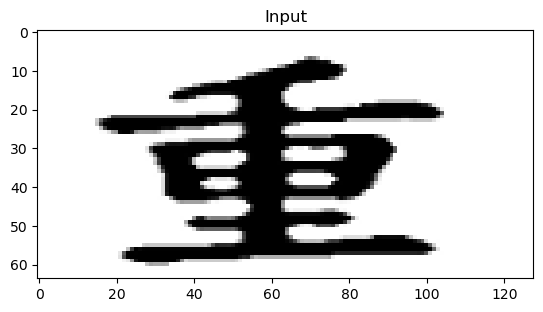

(64, 128), 2


In [135]:
ratio = math.ceil(ratio)
imgH = model_height
imgW = model_height * ratio

# resize takes (cols, rows)
img = cv2.resize(img0, (int(model_height*ratio), model_height),
                 interpolation=cv2.INTER_CUBIC)
plt_img(img)
print(f'{img.shape}, {ratio}')

### Transform data values from 0..255 to -1.0..1.0

In [136]:
transform = NormalizePAD((1, imgH, imgW))
input_data = transform(img)
input_data.shape, input_data.dtype

((1, 64, 128), dtype('float32'))

### Add a dimension for the model input

In [137]:
input_data = np.expand_dims(input_data, axis=0)
input_data.shape, input_data.dtype

((1, 1, 64, 128), dtype('float32'))

### Run the dynamic model with onnxruntime

In [138]:
on = onnxruntime.InferenceSession(recognizer_file,
                                  providers=['CPUExecutionProvider'])
inputs = {on.get_inputs()[0].name: input_data}
outputs = on.run(None, inputs)
outputs

[array([[[80.44098 , 60.83172 , 63.525032, ..., 61.943897, 61.063457,
          60.95753 ],
         [32.790264, 32.697216, 37.970303, ..., 34.41221 , 33.676098,
          34.355595],
         [69.02749 , 53.66711 , 58.422363, ..., 56.248894, 54.5758  ,
          55.42953 ],
         ...,
         [35.17361 , 15.170984, 16.157652, ..., 13.964742, 13.614969,
          12.129305],
         [47.037323, 25.743423, 25.025434, ..., 25.935553, 25.98571 ,
          24.56919 ],
         [53.308437, 33.852543, 33.71984 , ..., 35.24823 , 34.471485,
          33.627705]]], dtype=float32)]

### Run the fixed model with onnxruntime

In [149]:
on = onnxruntime.InferenceSession(fixed_recognizer_file,
                                  providers=['CPUExecutionProvider'])
inputs = {on.get_inputs()[0].name: input_data}
outputs = on.run(None, inputs)
outputs

[array([[[80.44098 , 60.83172 , 63.525032, ..., 61.943897, 61.063457,
          60.95753 ],
         [32.790264, 32.697216, 37.970303, ..., 34.41221 , 33.676098,
          34.355595],
         [69.02749 , 53.66711 , 58.422363, ..., 56.248894, 54.5758  ,
          55.42953 ],
         ...,
         [35.17361 , 15.170984, 16.157652, ..., 13.964742, 13.614969,
          12.129305],
         [47.037323, 25.743423, 25.025434, ..., 25.935553, 25.98571 ,
          24.56919 ],
         [53.308437, 33.852543, 33.71984 , ..., 35.24823 , 34.471485,
          33.627705]]], dtype=float32)]

### Run the fixed model with opencv

In [147]:
cv_net = cv2.dnn.readNetFromONNX(fixed_recognizer_file)
print('OpenCV model was successfully read.')#. Layer IDs: \n', opencv_net.getLayerNames())

OpenCV model was successfully read.


In [148]:
cv_net.setInput(input_data)
cv_outputs = cv_net.forward()
cv_outputs

array([[[80.44097 , 60.831722, 63.52504 , ..., 61.943893, 61.06346 ,
         60.957535],
        [32.79029 , 32.697254, 37.970364, ..., 34.412247, 33.67614 ,
         34.355644],
        [69.027405, 53.667057, 58.42234 , ..., 56.248848, 54.575783,
         55.429523],
        ...,
        [35.173626, 15.171019, 16.157688, ..., 13.964776, 13.614999,
         12.129333],
        [47.037327, 25.74345 , 25.025452, ..., 25.935566, 25.985737,
         24.56921 ],
        [53.308434, 33.85254 , 33.719833, ..., 35.24823 , 34.471485,
         33.627693]]], dtype=float32)

### Match the character

In [150]:
cv2.__version__

'4.9.0'